In [45]:
import gym
import numpy as np
import matplotlib.pyplot as plt

La idea del Q learning es generar unos valores Q, de manera que ir atravez de una serie de estados se tomen las acciones ideales y que el algoritmo sea capaz de optimizar en el largo plazo en vez de las soluciones en corto plazo. Q Learning es bueno para ambientes mas simples, para problemas mas complejos es recomendado usar modelos mas complejos 

In [46]:
## Creacion del ambiente
env = gym.make("MountainCar-v0")
env.reset() # se reinicia el ambiente, y podemos iterar sobre el ambiente

array([-0.5228078,  0.       ], dtype=float32)

In [47]:
### en este caso conocemos los valores maximos y minimos, pero no es el caso para todos los ambientes de 
### aprendizaje reforzado
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.n)


print((env.observation_space.high - env.observation_space.low)/([20] * len(env.observation_space.high)))
print([20] * len(env.observation_space.high) + [env.action_space.n])

[0.6  0.07]
[-1.2  -0.07]
3
[0.09  0.007]
[20, 20, 3]


## Acciones de MountainCar-v0

Por simplicidad elegimos el modelo de mountain car que puede funcionar con variables discretas.
### Accciones

el espacio de acciones, es un espacio discreto de tres acciones.

- acelerar hacia adelante = 0
- acelerar hacia atras = 2
- no hacer nada = 1

## Observaciones de MountainCar-v0

### Observaciones

este modelo tiene 2 variables de observaciones 

- Observation High - Contiene los maximos de las observaciones
- Observation Low - contiene los minimos de las observaciones

estos dos estan compuestos por una lista de dos elementos uno contienen los valores del eje X y el otro los valores del eje Y
 [0, 1] , donde 0 es la posicion en el eje X del Carro y 1 es la posicion Y del carro.

 ## Dinamica del modelo 

el modelo tambien evalua la velocidad y la posicion del carro de la siguiente manera


- $Vel = vel_{t + 1} = vel_t + (accionn -1) * fuerza -  \cos(3*posicion*gravedad) $

- $ Posicion_{t + 1} = posicion_t + velocidad_t +1 $

los valores de la fuerza y la gravedad son valores fijos dados por el modelo estos son

- $ fuerza = 0.001 $

- $ gravedad = 0.0025 $



## Recompenzas del modelo

el modelo se recompenza cada vez que llega a la menta y su objetivo es llegar a la meta en el menor tiempo posible, el agente se penaliza con una recompenza de -1 por cad paso de tiempo.

## Estado inicial del modelo.

La velocidad inicial del modelo siempre es 0  y se le asigna un valor aleatorio para la posicion entre [-0.6 y -0.4]

## Fin del episodio

un episodio terminara en el caso que se cumpla una de dos condiciones
1. se termina el juego al alcanzar la peta donde la posicion sobre el eje X sea igual o mayor a 0.5 que es la meta en el juego
2. truncamiento, cuando la longitud de lepisodio sea de 200.

     Es importante notar esta segunda condicion pues podremos evaluar las recompenzas del modelo, de esta manera podremos ver que el peor comportamiento que tendremos sera de -200 que seria la recompenza donde no logro termiar.







In [48]:
## Varibles iniciales y c

SHOW_EVERY = 2500 # renderiza el ejercicio cada n cantidad e iteraciones
LEARNING_RATE = 0.1 # es una variable que se encuentra entre 0 y 1 tambien se le puede dar decaimiento
DISCOUNT = 0.95 # que tan importantes son las acciones futuras sobre las actuales es una ponderacion de que tan importante encontramos lols valores futuros
EPISODIOS = 25000 # numero de repeticiones que ejecutaremos el algoritmo

mat_size = 20 
# podemos investigr como modificar los valores de esta matriz para que se adapten al tamño de los rangos que tienen 
# lo podemos optimizar mas adelante 


DISCRETE_SIZE = [mat_size] * len(env.observation_space.high) # Definimos el tamaño de la matriz 
discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/DISCRETE_SIZE # discretizamos las observaciones
## en este caso lo que estamos haciendo es que estamos tomando el rango total de nuestras observaciones y lo estamos dividiendo en la cantid designada 
## en discrete size


epsilon = 0.9 # entre 0 y 1  es la probabilidad de elegir una accion aleatoria a mayor epsilon mas explorcion
START_EPSILON_DECAYING = 1 # decaimiento del epsilon para que a medida   que avnce el algoritmo reduzca la aletoriedad
END_EPSILON_DECAYING = EPISODIOS // 2 # cuando se detiene el decaimiento del epsilon
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING) # esta es la cantidad que va a decaer epsilon


## Variables Globales

q_table = np.random.uniform(low = -2, high = 0, size = (DISCRETE_SIZE + [env.action_space.n])) # esto me crea una tabla de 20x20xn donde n es el numero de acciones
## los valores low y High varian entre ambientes  en este caso usaremos valores en los negativos pues el valor de "castigo" es -1 y el valor de recompensa es de 0


## usaremos los siguientes elementos para medir el rendimiento de nuestro algoritmo
ep_rewards = [] # guarda la recompenza de cada episodio

aggr_ep_rewards = {'ep' : [], 'avg': [], 'min': [], 'max':[]} # parametros para medir el rendimiento


## Descripcion de la Tabla Q 

 esta es una tabla probabilistica, por lo tanto el algoritmo elegira cual es la accion dado un estado que retorna la posible recompenza mas alta.
 basandonos en todas las posibilidades que tenemos de posicion y velocidad, cada combinacion de los estados con las posiciones 
 se le atribuye un puntaje, a mayor puntaje mejor el resultado.
 el objetivo de esto es que cuando la tabla Q esta completamente entrenada, dado una combinacion de estados 
 el algoritmo elegira la accion con un valor Q mas alto.
 Inicialmente la tabla Q se genera con valores aleatorios y mediante exploracion y experimentacion se iran populando estos valores


 ## discretizacion de la tabla Q

 hay multiples maneras de construir la tabla Q, nosotros usaremos uno de los metodos mas sencillos para la construccion de esta que es basicamente discretizar la cantidad de posibles estados y generando una matriz de tamaño S1 X S2 ... X SN X A

 sea Sn cada variable estado disponible discretizada para hacer mas facil el procesamiento
 A es todas las posibles acciones que tenemos

 ## Caso actual

 Para el caso actual construimos una matriz Q donde tomamos los rangos de los estados y los dividimos en una cantidad discreta digamos 20 y tenemos 3 acciones, por lo tanto en este caso tendremos una matriz de 20 x 20 x n, algo que podemos usar para experimentr es como afecta el cambio de la division y la discretizacion el entrenamiento del modelo.

## Epsilon



In [49]:
def get_discrete_satate(state):
    """ esta funcion toma un estado y lo transforma a numeros discretos
        Variable state
    """
    discrete_state = (state - env.observation_space.low)/discrete_os_win_size
    return tuple(discrete_state.astype(int))


episode: 0, avg: -200.0, min: -200.0, max: -200.0
Logramos el Objetivo en el episodio:1110 
Logramos el Objetivo en el episodio:1119 
Logramos el Objetivo en el episodio:1329 
Logramos el Objetivo en el episodio:1349 
Logramos el Objetivo en el episodio:1359 
Logramos el Objetivo en el episodio:1375 
Logramos el Objetivo en el episodio:1382 
Logramos el Objetivo en el episodio:1391 
Logramos el Objetivo en el episodio:1394 
Logramos el Objetivo en el episodio:1399 
Logramos el Objetivo en el episodio:1433 
Logramos el Objetivo en el episodio:1550 
Logramos el Objetivo en el episodio:1673 
Logramos el Objetivo en el episodio:1706 
Logramos el Objetivo en el episodio:1709 
Logramos el Objetivo en el episodio:1746 
Logramos el Objetivo en el episodio:1850 
Logramos el Objetivo en el episodio:1852 
Logramos el Objetivo en el episodio:1857 
Logramos el Objetivo en el episodio:1858 
Logramos el Objetivo en el episodio:1859 
Logramos el Objetivo en el episodio:1871 
Logramos el Objetivo en el

AttributeError: 'float' object has no attribute 'items'

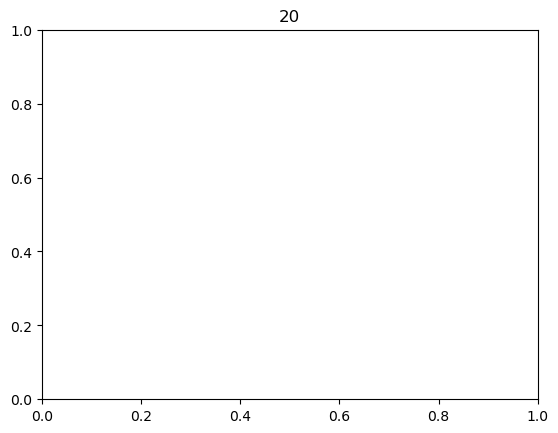

In [50]:
# se inicia el ciclo que recorrera los episodios
mat_size = 20 


for i in range(0,10):

    q_table = np.random.uniform(low = -2, high = 0, size = (DISCRETE_SIZE + [env.action_space.n]))
    epsilon = 0.5
    ep_rewards = []
    aggr_ep_rewards = {'ep' : [], 'avg': [], 'min': [], 'max':[]}
 
    for episode in range(EPISODIOS):
        episode_reward = 0 # establece la recompenza del episodio en 0 para iniciar la iteracion

        ## establece la ejecucion del renderizado del Episodio cada cierto tiempo

        if episode % SHOW_EVERY == 0:
            render = True
        else:
            render = False
            
        discrete_state = get_discrete_satate(env.reset())
        
        
        done = False ## ser genera un marcador para comenzar con las iteraciones.



        while not done:
            ## Se declaran las acciones que va a declarar el algoritmo y se comparan con el epsilon para generar 
            ## pseudoaleatoriamente si explora o maximiza
            if np.random.random() > epsilon:

                action = np.argmax(q_table[discrete_state]) # en este caso entrenara con el mejor resultado segun la tabla Q  es decir opera con el mejor resultado

            else:

                action = np.random.randint(0, env.action_space.n) # en este caso entrenara con una accion aleatoria
    
            new_state, reward ,done, _ = env.step(action) # se genera un nuevo episodio con la informacion de la accion declarada anteriormente
            ## el nuevo estasdo es el estado actual donde se encuentra el agente en este caso toma posicion y velocidad

            
            ## Almacenamos la recompenza del episodio
            episode_reward += reward
            # se discretiza el nevo estado 
            new_discrete_state  = get_discrete_satate(new_state)

            if render:
                env.render() # esto lo hacemos para ver la evolucion del algoritmo cada n episodios
            
            if not done:
                max_future_q = np.max(q_table[new_discrete_state]) # le aplicaremos el descuento  max_future_q 
                current_q = q_table[discrete_state + (action, )] # obtenemos el valor exacto de la Q  actual

                new_q = (1- LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)   # formula para calcular los valores Q
                q_table[discrete_state + (action,)] = new_q # actualizamos los valores Q para la tabla Q con el nuevo valor que obtuvimos anteriormente
            elif new_state[0] >= env.goal_position:
                print(f"Logramos el Objetivo en el episodio:{episode} ")
                q_table[discrete_state + (action, )] = 0
        # se establece el nuevo estado
            discrete_state = new_discrete_state
        # decae el epsilon
        if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
            epsilon -= epsilon_decay_value
        
        ## se imprimen los valores de las recompenzas
        ep_rewards.append(episode_reward)

        if not episode % SHOW_EVERY:
            average_reward = sum(ep_rewards[-SHOW_EVERY:])/len(ep_rewards[-SHOW_EVERY:])
            aggr_ep_rewards['ep'].append(episode)
            aggr_ep_rewards['avg'].append(average_reward)
            aggr_ep_rewards['min'].append(min(ep_rewards[-SHOW_EVERY:]))
            aggr_ep_rewards['max'].append(max(ep_rewards[-SHOW_EVERY:]))
            
            print(f"episode: {episode}, avg: {average_reward}, min: {min(ep_rewards[-SHOW_EVERY:])}, max: {max(ep_rewards[-SHOW_EVERY:])}")

    env.close()
    plt.title(mat_size, epsilon)
    plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label = 'avg' )
    plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label = 'min' )
    plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label = 'max' )
    plt.legend(loc = 4)
    plt.show()
    
mat_size += 1

In [ ]:
env.close()